# import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pvlib as pvlib
import warnings
warnings.filterwarnings('ignore')

# define PV system

## Define Location

In [44]:
tz_local='US/Mountain'
location = pvlib.location.Location(latitude=32.2,longitude=-111,tz='UTC',altitude= 700,name='Tuscon')

# download TMY

In [19]:
api_key='your+api_key'
interval='60'
utc='true'
attributes = 'ghi,dhi,dni,wind_speed_10m_nwp,surface_air_temperature_nwp'
leap_year = 'false'
name  = 'your+name'
reason_for_use = 'your+use
affiliation = 'your+affiliation'
email = 'your+email'
mailing_list = 'false'

# get data
df = pd.read_csv('http://developer.nrel.gov/api'
                 '/solar/nsrdb_0512_download.csv?wkt=POINT({lon}%20{lat})&'
                 'names={year}&leap_day={leap}&interval={interval}&utc={utc}&'
                 'full_name={name}&email={email}&affiliation={affiliation}&'
                 'mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'
                 .format(year='tmy', lat=location.latitude, lon=location.longitude, leap=leap_year, interval=interval, utc=utc, 
                         name=name, email=email, mailing_list=mailing_list, affiliation=affiliation, 
                         reason=reason_for_use, api=api_key, attr=attributes), skiprows=2)
df=df.set_index(pd.DatetimeIndex(pd.to_datetime(df[['Year','Month','Day','Hour','Minute']],utc=True)))
df=df.drop(['Year','Month','Day','Hour','Minute'],axis='columns')

# modify weather data column names to match pvlib conventions
df.columns=df.rename(str.lower,axis='columns').columns.str.replace(' ','_')
df.head()

,ghi,dhi,dni,wind_speed,temperature
1998-01-01 00:00:00,58,24,417,1,13.481714
1998-01-01 01:00:00,0,0,0,1,12.333429
1998-01-01 02:00:00,0,0,0,2,11.381097
1998-01-01 03:00:00,0,0,0,2,10.440576
1998-01-01 04:00:00,0,0,0,2,9.568597


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 1998-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 6 columns):
ghi            8760 non-null int64
dhi            8760 non-null int64
dni            8760 non-null int64
wind_speed     8760 non-null int64
temperature    8760 non-null float64
temp_air       8760 non-null int64
dtypes: float64(1), int64(5)
memory usage: 799.1 KB


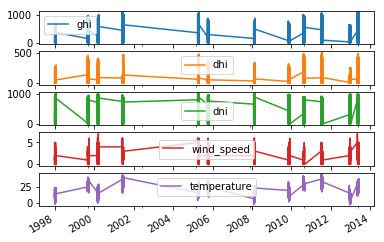

In [20]:
df.plot(subplots=True)
plt.show()

# Fixed Tilt Example

## Define system design

In [9]:
# define modules and inverters
cec_modules=pvlib.pvsystem.retrieve_sam('CECMod')
module=cec_modules['Yingli_Energy__China__YL300P_35b']
cec_inverters=pvlib.pvsystem.retrieve_sam('CECInverter')
inverter=cec_inverters['SMA_America__SC800CP_US_360V__CEC_2012_']

#missing module parameters for Desoto Model
module=module.append(pd.Series([1.121,-0.0002677],index=['EgRef','dEgdT']))

# define the pvsystem
system=pvlib.pvsystem.PVSystem(surface_tilt=22.5,
                        surface_azimuth=180,
                        albedo=.2,
                        modules_per_string=30,
                        strings_per_inverter=100,
                        module_parameters=module,
                        inverter_parameters=inverter,
                        name=location.name)
print(system)
print('module specs')
print(module)
print('inverter specs')
print(inverter)

PVSystem: 
  name: Tuscon
  surface_tilt: 22.5
  surface_azimuth: 180
  module: None
  inverter: None
  albedo: 0.2
  racking_model: open_rack_cell_glassback
module specs
BIPV                   N
Date            7/1/2013
T_NOCT              45.3
A_c                 1.95
N_s                   72
I_sc_ref            8.77
V_oc_ref            46.3
I_mp_ref            8.17
V_mp_ref            36.7
alpha_sc        0.004122
beta_oc         -0.17038
a_ref             1.9359
I_L_ref            8.784
I_o_ref        3.542e-10
R_s                0.489
R_sh_ref          296.18
Adjust           -0.6356
gamma_r            -0.46
Version           NRELv1
PTC                270.7
Technology    Multi-c-Si
EgRef              1.121
dEgdT         -0.0002677
dtype: object
inverter specs
Vac          3.600000e+02
Paco         8.230000e+05
Pdco         8.385667e+05
Vdco         6.357582e+02
Pso          2.247796e+03
C0          -1.640000e-08
C1           1.640000e-05
C2           2.860000e-03
C3           6.35

## Define the Irradiance and PV Modeling Methods

In [89]:
mc=pvlib.modelchain.ModelChain(system,location,
                               aoi_model='physical',
                               transposition_model='perez',
                               dc_model='singlediode',
                               ac_model='snlinverter',
                               spectral_model='no_loss',
                               losses_model='pvwatts',
                               name=location.name)
print(mc)

ModelChain: 
  name: Tuscon
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: perez
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: singlediode
  ac_model: snlinverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temp_model: sapm_temp
  losses_model: pvwatts_losses


## Run the Model
The model runs with some warnings

In [90]:
#run model
mc.run_model(times=df.index,weather=df)

# combine results into existing
df_fixed=pd.concat([df,mc.total_irrad],axis=1)
df_fixed=pd.concat([df_fixed,mc.temps],axis=1)
df_fixed=pd.concat([df_fixed,mc.dc],axis=1)
df_fixed['p_ac']=mc.ac

# convert to local timezone
df_fixed.index=df_fixed.index.tz_localize('UTC').tz_convert(tz_local)
df_fixed.head()

C:\Users\slightfoote\AppData\Local\Continuum\anaconda3\lib\site-packages\pvlib\irradiance.py:1002: RuntimeWarning: invalid value encountered in less
  ebin[eps < 1.065] = 1
C:\Users\slightfoote\AppData\Local\Continuum\anaconda3\lib\site-packages\pvlib\irradiance.py:1003: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.065) & (eps < 1.23)] = 2
C:\Users\slightfoote\AppData\Local\Continuum\anaconda3\lib\site-packages\pvlib\irradiance.py:1003: RuntimeWarning: invalid value encountered in less
  ebin[(eps >= 1.065) & (eps < 1.23)] = 2
C:\Users\slightfoote\AppData\Local\Continuum\anaconda3\lib\site-packages\pvlib\irradiance.py:1004: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.23) & (eps < 1.5)] = 3
C:\Users\slightfoote\AppData\Local\Continuum\anaconda3\lib\site-packages\pvlib\irradiance.py:1004: RuntimeWarning: invalid value encountered in less
  ebin[(eps >= 1.23) & (eps < 1.5)] = 3
C:\Users\slightfoote\AppData\Local\Continuum\anac

,ghi,dhi,dni,wind_speed,temperature,temp_air,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,...,temp_cell,temp_module,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx,p_ac
1997-12-31 17:00:00-07:00,58,24,417,1,13.481714,20,152.374437,114.130173,38.244264,37.802765,...,24.925123,24.468,113.002614,1270.393651,105.735636,1082.40773,114449.070142,112.080735,84.062923,93528.897348
1997-12-31 18:00:00-07:00,0,0,0,1,12.333429,20,0.000000,0.000000,0.000000,0.000000,...,20.000000,20.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-311.819427
1997-12-31 19:00:00-07:00,0,0,0,2,11.381097,20,0.000000,-0.000000,0.000000,0.000000,...,20.000000,20.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-311.819427
1997-12-31 20:00:00-07:00,0,0,0,2,10.440576,20,0.000000,-0.000000,0.000000,0.000000,...,20.000000,20.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-311.819427
1997-12-31 21:00:00-07:00,0,0,0,2,9.568597,20,0.000000,-0.000000,0.000000,0.000000,...,20.000000,20.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-311.819427


## Supporting Plots

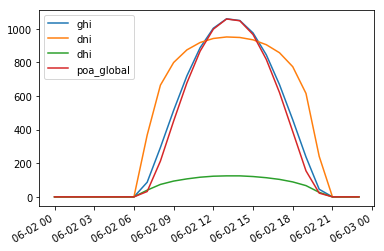

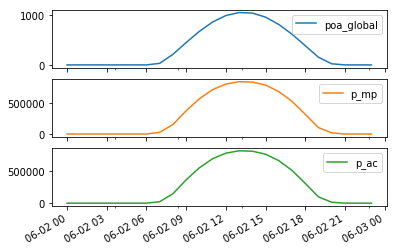

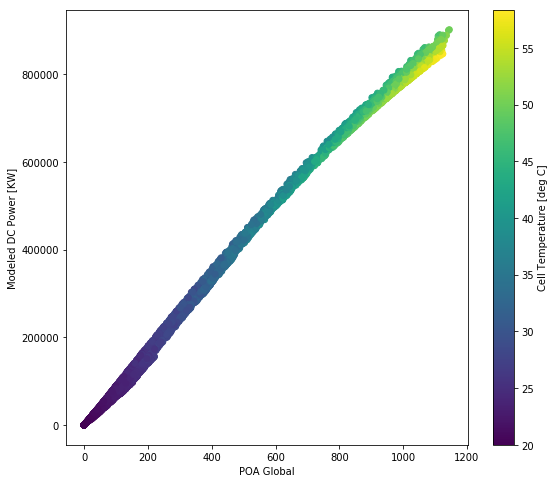

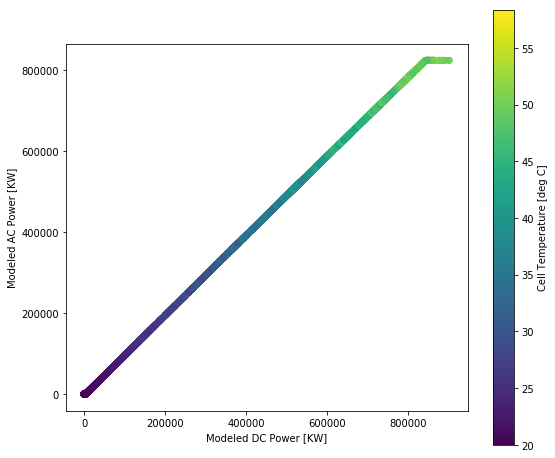

In [85]:
df_fixed.loc['2001-06-02',['ghi','dni','dhi','poa_global']].plot()
plt.show()

df_fixed.loc['2001-06-02',['poa_global','p_mp','p_ac']].plot(subplots=True)
plt.show()

fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111)
sc = ax.scatter(x=df_fixed['poa_global'],y=df_fixed['p_mp'],c=df_fixed['temp_cell'])
ax.set_xlabel('POA Global')
ax.set_ylabel('Modeled DC Power [KW]')
fig.colorbar(sc, label='Cell Temperature [deg C]')
plt.show()

fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, aspect='equal')
sc = ax.scatter(x=df_fixed['p_mp'],y=df_fixed['p_ac'],c=df_fixed['temp_cell'])
ax.set_xlabel('Modeled DC Power [KW]')
ax.set_ylabel('Modeled AC Power [KW]')
fig.colorbar(sc, label='Cell Temperature [deg C]')
plt.show()

## Totals

In [113]:
df_fixed['month']=df_fixed.index.month
monthly_fixed=df_fixed[['month','ghi','poa_global','p_mp','p_ac']].groupby('month').sum()*.001
monthly_fixed['total_losses']=1-monthly_fixed.p_ac/monthly_fixed.p_mp
round(monthly_fixed,3)

,ghi,poa_global,p_mp,p_ac,total_losses
month,,,,,
1,113.632,166.664,137061.186,114781.852,0.163
2,128.575,169.766,138087.937,115620.240,0.163
3,182.705,213.372,171810.433,143473.993,0.165
4,224.704,236.777,190086.183,158340.778,0.167
5,261.215,253.149,203761.320,170356.862,0.164
6,252.698,236.341,190709.593,159604.053,0.163
7,217.093,208.465,170002.132,142168.306,0.164
8,205.313,210.108,170508.721,142659.488,0.163
9,180.718,203.750,164347.603,137584.247,0.163


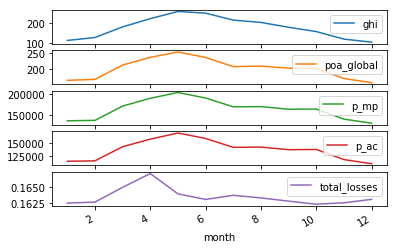

In [119]:
monthly_fixed.plot(subplots=True)
plt.show()

In [114]:
round(monthly_fixed.agg(['sum','mean']),3)

,ghi,poa_global,p_mp,p_ac,total_losses
sum,2150.787,2432.981,1973543.844,1650643.654,1.962
mean,179.232,202.748,164461.987,137553.638,0.164


# Single Axis Tracking Example

## Define system design

In [80]:
tracking_system= pvlib.tracking.SingleAxisTracker(albedo=.2,
                        modules_per_string=30,
                        strings_per_inverter=100,
                        module_parameters=module,
                        inverter_parameters=inverter,
                        name=location.name+' Tracking',
                        axis_tilt=0,
                        axis_azimuth=180,
                        max_angle=52,
                        backtrack=True,
                        gcr=.5)
print(tracking_system)

SingleAxisTracker: 
  axis_tilt: 0
  axis_azimuth: 180
  max_angle: 52
  backtrack: True
  gcr: 0.5
  name: Tuscon Tracking
  surface_tilt: None
  surface_azimuth: None
  module: None
  inverter: None
  albedo: 0.2
  racking_model: open_rack_cell_glassback


## Define the Irradiance and PV Modeling Methods

In [86]:
mc=pvlib.modelchain.ModelChain(tracking_system,
                               location,
                               aoi_model='physical',
                               transposition_model='perez',
                               dc_model='singlediode',
                               ac_model='snlinverter',
                               spectral_model='no_loss',
                               losses_model='pvwatts',
                               name=tracking_system.name)
print(mc)

ModelChain: 
  name: Tuscon Tracking
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: perez
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: singlediode
  ac_model: snlinverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temp_model: sapm_temp
  losses_model: pvwatts_losses


## Run the Model
The model runs with some warnings

In [87]:
#run model
mc.run_model(times=df.index,weather=df)

# combine results into existing
df_tracking=pd.concat([df,mc.total_irrad],axis=1)
df_tracking=pd.concat([df_tracking,mc.temps],axis=1)
df_tracking=pd.concat([df_tracking,mc.dc],axis=1)
df_tracking['p_ac']=mc.ac

# convert to local timezone
df_tracking.index=df_tracking.index.tz_localize('UTC').tz_convert(tz_local)
df_tracking.head()

C:\Users\slightfoote\AppData\Local\Continuum\anaconda3\lib\site-packages\pvlib\tracking.py:423: RuntimeWarning: invalid value encountered in minimum
  temp = np.minimum(axes_distance*cosd(wid), 1)
C:\Users\slightfoote\AppData\Local\Continuum\anaconda3\lib\site-packages\pvlib\irradiance.py:1002: RuntimeWarning: invalid value encountered in less
  ebin[eps < 1.065] = 1
C:\Users\slightfoote\AppData\Local\Continuum\anaconda3\lib\site-packages\pvlib\irradiance.py:1003: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.065) & (eps < 1.23)] = 2
C:\Users\slightfoote\AppData\Local\Continuum\anaconda3\lib\site-packages\pvlib\irradiance.py:1003: RuntimeWarning: invalid value encountered in less
  ebin[(eps >= 1.065) & (eps < 1.23)] = 2
C:\Users\slightfoote\AppData\Local\Continuum\anaconda3\lib\site-packages\pvlib\irradiance.py:1004: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.23) & (eps < 1.5)] = 3
C:\Users\slightfoote\AppData\Local\Contin

,ghi,dhi,dni,wind_speed,temperature,temp_air,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,...,temp_cell,temp_module,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx,p_ac
1997-12-31 17:00:00-07:00,58,24,417,1,13.481714,20,99.570614,69.761418,29.809196,29.781045,...,23.218372,22.91966,64.158931,1247.114925,60.034592,1066.988958,64056.246473,63.644652,48.212685,50557.857129
1997-12-31 18:00:00-07:00,0,0,0,1,12.333429,20,0.000000,-0.000000,0.000000,0.000000,...,20.000000,20.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-311.819427
1997-12-31 19:00:00-07:00,0,0,0,2,11.381097,20,0.000000,-0.000000,0.000000,0.000000,...,20.000000,20.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-311.819427
1997-12-31 20:00:00-07:00,0,0,0,2,10.440576,20,0.000000,-0.000000,0.000000,0.000000,...,20.000000,20.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-311.819427
1997-12-31 21:00:00-07:00,0,0,0,2,9.568597,20,0.000000,-0.000000,0.000000,0.000000,...,20.000000,20.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-311.819427


## Supporting Plots

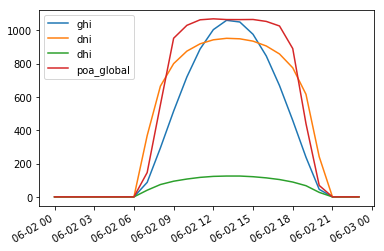

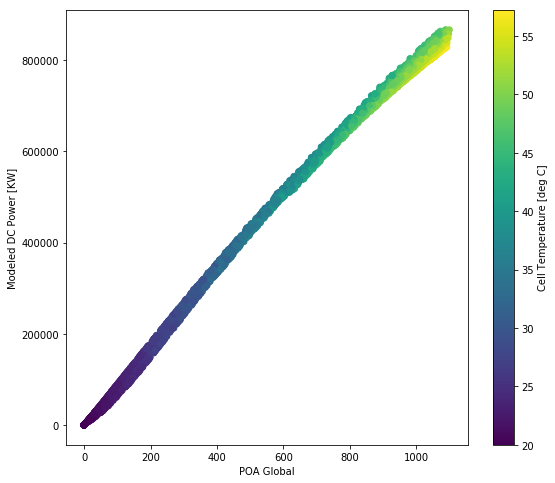

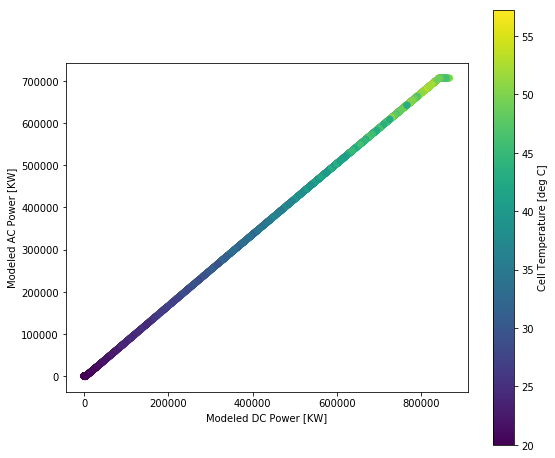

In [88]:
df_tracking.loc['2001-06-02',['ghi','dni','dhi','poa_global']].plot()
plt.show()

fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111)
sc = ax.scatter(x=df_tracking['poa_global'],y=df_tracking['p_mp'],c=df_tracking['temp_cell'])
ax.set_xlabel('POA Global')
ax.set_ylabel('Modeled DC Power [KW]')
fig.colorbar(sc, label='Cell Temperature [deg C]')
plt.show()

fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, aspect='equal')
sc = ax.scatter(x=df_tracking['p_mp'],y=df_tracking['p_ac'],c=df_tracking['temp_cell'])
ax.set_xlabel('Modeled DC Power [KW]')
ax.set_ylabel('Modeled AC Power [KW]')
fig.colorbar(sc, label='Cell Temperature [deg C]')
plt.show()

## Totals

In [115]:
df_tracking['month']=df_tracking.index.month
monthly_tracking=df_tracking[['month','ghi','poa_global','p_mp','p_ac']].groupby('month').sum()*.001
monthly_tracking['total_losses']=1-monthly_tracking.p_ac/monthly_tracking.p_mp
round(monthly_tracking,3)

,ghi,poa_global,p_mp,p_ac,total_losses
month,,,,,
1,113.731,152.638,126737.565,106122.245,0.163
2,128.716,170.496,140399.264,117612.435,0.162
3,182.883,238.227,192926.824,161570.775,0.163
4,224.811,293.429,235468.961,197276.421,0.162
5,261.350,339.883,271432.422,226980.243,0.164
6,252.760,326.049,260367.923,217996.654,0.163
7,216.895,270.321,218274.361,182793.195,0.163
8,204.919,255.156,206228.325,172737.417,0.162
9,180.755,235.630,190963.739,160019.734,0.162


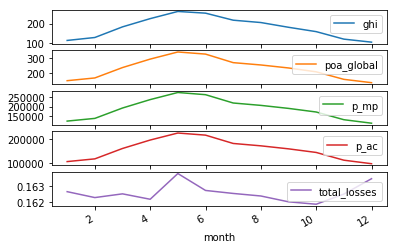

In [118]:
monthly_tracking.plot(subplots=True)
plt.show()

In [116]:
round(monthly_tracking.agg(['sum','mean']),3)

,ghi,poa_global,p_mp,p_ac,total_losses
sum,2150.787,2793.372,2265358.005,1896993.899,1.951
mean,179.232,232.781,188779.834,158082.825,0.163
